In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, special
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{bm}'

In [42]:
delta = 0.0001
w0 = 0.01
EF = 1
m = 1
h_bar = 1
kF = np.sqrt(2*m*EF) / h_bar
xi_c = 2 * EF / (kF * delta)
l_0  = 2 * EF / (kF * h_bar * w0)
print(f'kF   = {kF}')
print(f'l_0  = {l_0}')
print(f'xi_c = {xi_c}')

l_0_tilde = l_0 / xi_c
rho_0 = 1 / (2 * np.pi**2) * kF * m / h_bar**2
n = kF**3 / (6 * np.pi**2)

kF   = 1.4142135623730951
l_0  = 141.42135623730948
xi_c = 14142.13562373095


In [43]:
def w(xi):
    return 1 / ((xi / (h_bar*w0))**4 + 1)

In [44]:
def f_integral_body(r_tilde, y):
    return 1 / np.sqrt(y*y - 1) * np.exp(-r_tilde * y) / ((l_0_tilde * y)**4 + 1)

def get_residue_f(r_tilde):
    return np.pi / 2 * np.exp(- r_tilde / (np.sqrt(2) * l_0_tilde)) * np.cos(r_tilde / (np.sqrt(2) * l_0_tilde))

def calc_I(r_tilde):
    integrals = np.array([integrate.quad(lambda y: f_integral_body(rt, y), 1, np.inf)[0] for rt in r_tilde])
    return integrals + get_residue_f(r_tilde)

def calc_f(rs):
    return 1 / (2 * np.pi**2) * kF / (xi_c * rs) * calc_I(rs / xi_c)
def calc_far_field_fs(rs):
    return 1 / (2 * np.pi**2) * kF / (xi_c * rs) * (special.k0(rs / xi_c) + get_residue_f(rs / xi_c))
def calc_near_field_fs(rs):
    int1, _ = integrate.quad(lambda y: 1 / (np.sqrt(y*y - 1) * ((l_0_tilde * y)**4 + 1)), 1, np.inf)
    int2, _ = integrate.quad(lambda y: y / (np.sqrt(y*y - 1) * ((l_0_tilde * y)**4 + 1)), 1, np.inf)
    return 1 / (2 * np.pi**2) * kF / (xi_c * rs) * (int1 - rs / xi_c * int2 + get_residue_f(rs / xi_c))

In [55]:
rs = np.exp(np.linspace(np.log(1e-2 * l_0), np.log(1e2 * l_0), 1000))
#rs = np.linspace(0.01 * l_0, 1 * l_0, 100)
fs = calc_f(rs) / n
far_field_fs = calc_far_field_fs(rs) / n
near_field_fs = calc_near_field_fs(rs) / n

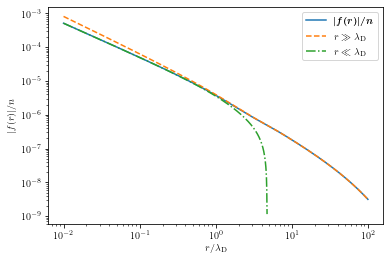

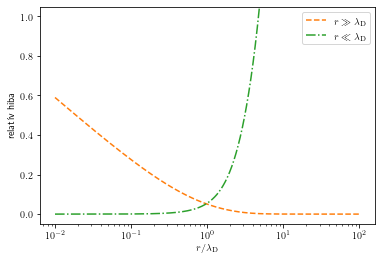

In [56]:
rs_norm = rs / l_0

plt.figure(1)
plt.loglog(rs_norm, np.abs(fs), label=r'$\boldsymbol{|f(r)| / n}$')
plt.plot(rs_norm, np.abs(far_field_fs), '--', label=r'$r \gg \lambda_\mathrm{D}$')
plt.plot(rs_norm[:669], np.abs(near_field_fs)[:669], '-.', label=r'$r \ll \lambda_\mathrm{D}$')
plt.xlabel(r'$r / \lambda_\mathrm{D}$')
plt.ylabel(r'$|f(r)| / n$')
plt.legend()

plt.savefig("../latex/F_sc.pdf", format="pdf", bbox_inches="tight")

plt.figure(2)
plt.semilogx(rs_norm, np.abs(fs - far_field_fs) / np.abs(fs), '--', label=r'$r \gg \lambda_\mathrm{D}$', color='tab:orange')
plt.plot(rs_norm, np.abs(fs - near_field_fs) / np.abs(fs), '-.', label=r'$r \ll \lambda_\mathrm{D}$', color='tab:green')
plt.ylim([-0.05, 1.05])
plt.xlabel(r'$r / \lambda_\mathrm{D}$')
plt.ylabel('relatív hiba')
plt.legend()

plt.savefig("../latex/F_sc_error.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [86]:
def g_integral_body_sc(r_tilde, y):
    return y / np.sqrt(y*y - 1) * np.exp(-r_tilde * y) / ((l_0_tilde * y)**4 + 1)
def g_integral_body_n(r_tilde, y):
    return (-1.j + y / (kF * xi_c)) * np.exp(-r_tilde * y) / ((l_0_tilde * y)**4 + 1)

def get_residue_g(r_tilde):
    R2n = (-1.j * np.pi / 2 - np.pi / (2 * kF * xi_c * l_0_tilde**2)) * np.exp(-1.j * r_tilde / (np.sqrt(2) * l_0_tilde)) * np.exp(-r_tilde / (np.sqrt(2) * l_0_tilde))
    x1 = (1.j + 1) / (np.sqrt(2) * l_0_tilde)
    x2 = (1.j - 1) / (np.sqrt(2) * l_0_tilde)
    R1sc = 1.j * np.pi / (4 * x1) * np.exp(1.j * r_tilde / (np.sqrt(2) * l_0_tilde)) * np.exp(-r_tilde / (np.sqrt(2) * l_0_tilde))
    R2sc = -1.j * np.pi * x2 / 2 * np.exp(-1.j * r_tilde / (np.sqrt(2) * l_0_tilde)) * np.exp(-r_tilde / (np.sqrt(2) * l_0_tilde))
    return -R2n + R1sc + R2sc

def calc_I_g(r_tilde):
    integrals_sc = np.array([integrate.quad(lambda y: g_integral_body_sc(rt, y), 1, np.inf)[0] for rt in r_tilde])
    integrals_n = np.array([
        integrate.quad(lambda y: np.real(g_integral_body_n(rt, y)), 0, np.inf)[0]
        + 1.j * integrate.quad(lambda y: np.imag(g_integral_body_n(rt, y)), 0, np.inf)[0]
        for rt in r_tilde
    ])
    return integrals_sc - integrals_n + get_residue_g(r_tilde)

def calc_g_normal(rs):
    return 1 / (2 * np.pi**2) * (1 - 1.j * kF * rs) / rs**3
def calc_g(rs):
    return calc_g_normal(rs) + 1 / (2 * np.pi**2) * kF / (xi_c * rs) * calc_I_g(rs / xi_c)
def calc_far_field_gs(rs):
    return 1 / (2 * np.pi**2) * kF / (xi_c * rs) * special.k1(rs / xi_c)
def calc_near_field_gs(rs):
    A = (integrate.quad(lambda y: y / np.sqrt(y*y - 1) / ((l_0_tilde * y)**4 + 1), 1, np.inf)[0]
        + 1.j * np.pi / (2 * np.sqrt(2) * l_0_tilde) - np.pi / (4 * kF * xi_c * l_0_tilde**2))
    B = (integrate.quad(lambda y: y*y / np.sqrt(y*y - 1) / ((l_0_tilde * y)**4 + 1), 1, np.inf)[0]
        + 1.j * np.pi / (4 * l_0_tilde**2) - np.pi / (2 * np.sqrt(2) * kF * xi_c * l_0_tilde**3))
    return 1 / (2 * np.pi**2) * (
        (1 - 1.j * kF * rs) / rs**3
        + kF / (xi_c * rs) * (A - B * rs / xi_c + get_residue_g(rs / xi_c))
    )

In [87]:
rs = np.exp(np.linspace(np.log(1e-3 * l_0), np.log(1e3 * l_0), 1000))
#rs = np.linspace(0.01 * l_0, 1 * l_0, 100)
gs = calc_g(rs) / n
far_field_gs = calc_far_field_gs(rs) / n
near_field_gs = calc_near_field_gs(rs) / n
normal_gs = calc_g_normal(rs) / n

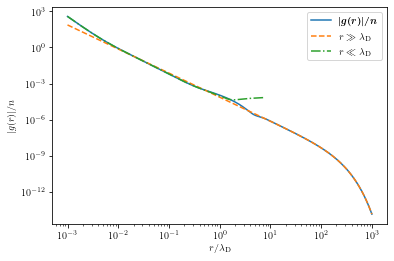

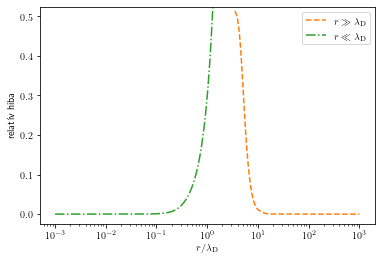

In [88]:
rs_norm = rs / l_0

plt.figure(1)
plt.loglog(rs_norm, np.abs(gs), label=r'$\boldsymbol{|g(r)| / n}$')
plt.plot(rs_norm, np.abs(far_field_gs), '--', label=r'$r \gg \lambda_\mathrm{D}$')
plt.plot(rs_norm[:650], np.abs(near_field_gs)[:650], '-.', label=r'$r \ll \lambda_\mathrm{D}$')
# plt.plot(rs_norm, np.abs(normal_gs), '-.', label=r'$r \ll \lambda_\mathrm{D}$')
plt.xlabel(r'$r / \lambda_\mathrm{D}$')
plt.ylabel('$|g(r)| / n$')
plt.legend()

plt.savefig("../latex/G_sc.pdf", format="pdf", bbox_inches="tight")

plt.figure(2)
plt.semilogx(rs_norm[590:], (np.abs(gs - far_field_gs) / np.abs(gs))[590:], '--', label=r'$r \gg \lambda_\mathrm{D}$', color='tab:orange')
plt.plot(rs_norm, np.abs(gs - near_field_gs) / np.abs(gs), '-.', label=r'$r \ll \lambda_\mathrm{D}$', color='tab:green')
plt.ylim([-0.025, 0.525])
plt.xlabel(r'$r / \lambda_\mathrm{D}$')
plt.ylabel('relatív hiba')
plt.legend()

plt.savefig("../latex/G_sc_error.pdf", format="pdf", bbox_inches="tight")

plt.show()

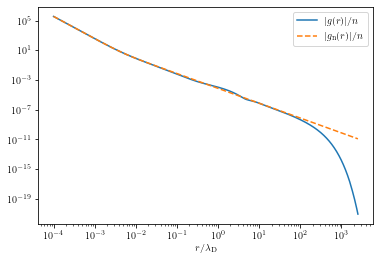

In [59]:
rs = np.exp(np.linspace(np.log(1e-4 * l_0), np.log(10**3.4 * l_0), 1000))
gs = calc_g(rs) / n
normal_gs = calc_g_normal(rs) / n
rs_norm = rs / l_0

plt.loglog(rs_norm, np.abs(gs), label='$|g(r)| / n$')
plt.plot(rs_norm, np.abs(normal_gs), '--', label=r'$|g_\mathrm{n}(r)| / n$')
plt.xlabel(r'$r / \lambda_\mathrm{D}$')
plt.ylabel('')
plt.legend()

plt.savefig("../latex/G_vs_G_n.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [89]:
rs = np.exp(np.linspace(np.log(1e-3 * l_0), np.log(1e3 * l_0), 1000))
rs_norm = rs / l_0

fs = calc_f(rs) / n
far_field_fs = calc_far_field_fs(rs) / n
near_field_fs = 0#calc_near_field_fs(rs) / n

gs = calc_g(rs) / n
far_field_gs = calc_far_field_gs(rs) / n
near_field_gs = calc_near_field_gs(rs) / n
normal_gs = calc_g_normal(rs) / n

In [90]:
def calc_square_bound(zs):
    return np.abs(zs)**2

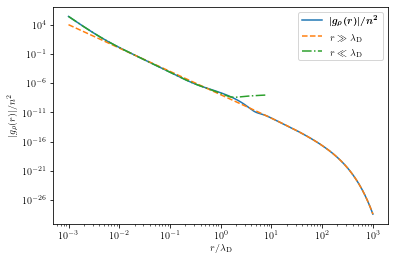

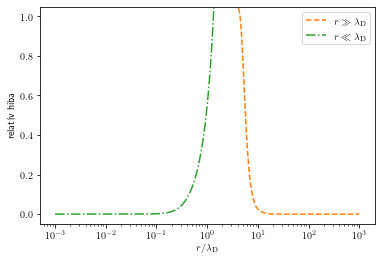

In [98]:
def calc_rhos(fs, gs):
    return 2 * fs**2 - 2 * gs**2

rhos = calc_rhos(fs, gs)
far_rhos = calc_rhos(far_field_fs, far_field_gs)
near_rhos = calc_rhos(near_field_fs, near_field_gs)

plt.figure(1)
plt.loglog(rs_norm, np.abs(rhos), label=r'$\boldsymbol{|g_\rho(r)| / n^2}$')
plt.plot(rs_norm, np.abs(far_rhos), '--', label=r'$r \gg \lambda_\mathrm{D}$')
plt.plot(rs_norm[:650], np.abs(near_rhos)[:650], '-.', label=r'$r \ll \lambda_\mathrm{D}$')
plt.xlabel(r'$r / \lambda_\mathrm{D}$')
plt.ylabel(r'$|g_\rho(r)| / n^2$')
plt.legend()

plt.savefig("../latex/rho.pdf", format="pdf", bbox_inches="tight")

rhos_complex = rhos
far_rhos_complex = far_rhos
near_rhos_complex = near_rhos

plt.figure(2)
plt.semilogx(rs_norm[600:], np.abs((rhos_complex - far_rhos_complex) / rhos_complex)[600:], '--', label=r'$r \gg \lambda_\mathrm{D}$', color='tab:orange')
plt.plot(rs_norm, np.abs((rhos_complex - near_rhos_complex) / rhos_complex), '-.', label=r'$r \ll \lambda_\mathrm{D}$', color='tab:green')
plt.ylim([-0.05, 1.05])
plt.xlabel(r'$r / \lambda_\mathrm{D}$')
plt.ylabel('relatív hiba')
plt.legend()

plt.savefig("../latex/rho_error.pdf", format="pdf", bbox_inches="tight")

plt.show()

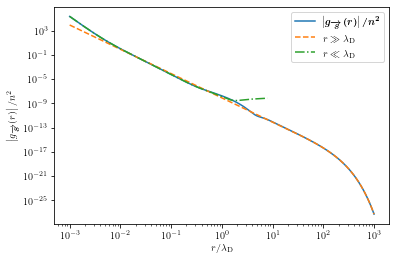

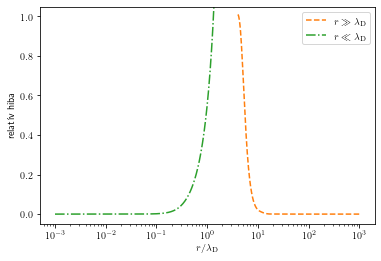

In [101]:
def calc_ss(fs, gs):
    return -3/2 * (fs**2 + gs**2)

ss = calc_ss(fs, gs)
far_ss = calc_ss(far_field_fs, far_field_gs)
near_ss = calc_ss(near_field_fs, near_field_gs)

plt.figure(1)
plt.loglog(rs_norm, np.abs(ss), label=r'$\boldsymbol{\left|g_{\overrightarrow{\bm{s}}}(r)\right| / n^2}$')
plt.plot(rs_norm, np.abs(far_ss), '--', label=r'$r \gg \lambda_\mathrm{D}$')
plt.plot(rs_norm[:650], np.abs(near_ss)[:650], '-.', label=r'$r \ll \lambda_\mathrm{D}$')
plt.xlabel(r'$r / \lambda_\mathrm{D}$')
plt.ylabel(r'$\left|g_{\overrightarrow{\bm{s}}}(r)\right| / n^2$')
plt.legend()

plt.savefig("../latex/s.pdf", format="pdf", bbox_inches="tight")

ss_complex = ss
far_ss_complex = far_ss
near_ss_complex = near_ss

plt.figure(2)
plt.semilogx(rs_norm[600:], np.abs((ss_complex - far_ss_complex) / ss_complex)[600:], '--', label=r'$r \gg \lambda_\mathrm{D}$', color='tab:orange')
plt.plot(rs_norm, np.abs((ss_complex - near_ss_complex) / ss_complex), '-.', label=r'$r \ll \lambda_\mathrm{D}$', color='tab:green')
plt.ylim([-0.05, 1.05])
plt.xlabel(r'$r / \lambda_\mathrm{D}$')
plt.ylabel('relatív hiba')
plt.legend()

plt.savefig("../latex/s_error.pdf", format="pdf", bbox_inches="tight")

plt.show()